In [113]:
import pandas as pd
import regex as re
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
def extractConfigurationCode(file_name):

    try:
        pixel_code = ""

        with open (file_name,'r') as f:
            for line in f:
                pixel_code+=line
        configuration = "fbq.registerPlugin" + (pixel_code.split('fbq.registerPlugin')[1].split('/*')[0])
        return configuration
    except:
        return None

In [86]:
def parseCode(pixel_code):

    # Regular expressions to capture different components
    plugin_pattern = r'fbq\.loadPlugin\("([^"]+)"\);'
    optin_pattern = r'instance\.optIn\("([^"]+)", "([^"]+)", (true|false)\);'
    config_set_pattern = r'config\.set\(([^,]+), "([^"]+)", ({.*?})\);'
    fbq_set_pattern = r'fbq\.set\("([^"]+)", "([^"]+)", (\[.*?\])\);'

    # Store extracted data
    plugins = re.findall(plugin_pattern, pixel_code)
    optins = re.findall(optin_pattern, pixel_code)
    config_sets = re.findall(config_set_pattern, pixel_code)
    fbq_sets = re.findall(fbq_set_pattern, pixel_code)

    # Output the results for analysis
    print("Plugins Loaded:")
    for plugin in plugins:
        print(f'  - {plugin}')

    print("\nInstance Opt-ins:")
    for optin in optins:
        print(f'  - Pixel ID: {optin[0]}, Configuration: {optin[1]}, Enabled: {optin[2]}')

    print("\nConfig Set Calls:")
    parsed_configs = []
    for config in config_sets:
        pixel_id = config[0]
        config_name = config[1]
        config_json = config[2]
        
        # Parse JSON from the config.set call
        try:
            config_data = json.loads(config_json)
            parsed_configs.append({ "pixel_id": pixel_id, "config_name": config_name, "config_data": config_data })
            print(f'  - Pixel ID: {pixel_id}, Configuration: {config_name}, Data: {json.dumps(config_data, indent=4)}')
        except json.JSONDecodeError:
            print(f"  - Error parsing JSON for {config_name} with pixel {pixel_id}")

    print("\nfbq.set Calls:")
    for fbq_set in fbq_sets:
        print(f'  - Configuration Name: {fbq_set[0]}, Pixel ID: {fbq_set[1]}, List: {fbq_set[2]}')

    # The parsed_configs list can be used for further analysis or manipulation

In [193]:
def preprocess_name(name):
    if name:
        return name.lower().replace('_', '').strip()

def parse_pixel_code(code):
    
    plugin_pattern = re.compile(r'fbq\.loadPlugin\("([\w]+)"\);')
    optin_pattern = re.compile(r'instance\.optIn\("([\d]+)",\s*"([\w]+)",\s*(true|false)\);')
    config_set_pattern = re.compile(r'config\.set\((?:"([\d]+)"|null),\s*"([\w]+)",\s*(\{.*?\})\);', re.DOTALL)
    fbq_set_pattern = re.compile(r'fbq\.set\("([\w]+)",\s*"([\d]+)",\s*(\[\s*\])\);', re.DOTALL)

    # Lists to store parsed data
    plugins = []
    optins = []
    config_sets = []
    fbq_sets = []


    # Parse plugins
    for match in plugin_pattern.findall(code):
        plugins.append(preprocess_name(match))

    # Parse opt-ins
    for match in optin_pattern.findall(code):
        pixel_id, config_name, enabled = match
        optins.append((pixel_id, preprocess_name(config_name), enabled))

    # Parse config.set
    for match in config_set_pattern.findall(code):
        pixel_id, config_name, config_data = match
        config_data_json = json.loads(config_data)  # Parse the config_data as JSON
        config_sets.append((pixel_id, preprocess_name(config_name), config_data_json))

    # Parse fbq.set
    for match in fbq_set_pattern.findall(code):
        config_name, pixel_id, config_list = match
        fbq_sets.append((preprocess_name(config_name), pixel_id, json.loads(config_list)))  # Parse the list


    rows = []

    # Iterate over the parsed data and create rows for the DataFrame
    max_len = max(len(plugins), len(optins), len(config_sets), len(fbq_sets))

    for i in range(max_len):
        row = {
            "plugin_name": plugins[i] if i < len(plugins) else None,
            "pixel_id": optins[i][0] if i < len(optins) else None,
            "opt_in_config_name": optins[i][1] if i < len(optins) else None,
            "opt_in_enabled": optins[i][2] if i < len(optins) else None,
            "config_set_pixel_id": config_sets[i][0] if i < len(config_sets) else None,
            "config_set_name": config_sets[i][1] if i < len(config_sets) else None,
            "config_set_data": config_sets[i][2] if i < len(config_sets) else None,
            "fbq_set_name": fbq_sets[i][0] if i < len(fbq_sets) else None,
            "fbq_set_pixel_id": fbq_sets[i][1] if i < len(fbq_sets) else None,
            "fbq_set_list": fbq_sets[i][2] if i < len(fbq_sets) else None
        }
        rows.append(row)


    df = pd.DataFrame(rows)
    return df

def parse_dataframe(df):

    plugin_pixel_list = df[['plugin_name', 'pixel_id']].values.tolist()
    opt_in_list = df[['opt_in_config_name', 'opt_in_enabled']].values.tolist()
    config_set_list = df[['config_set_name', 'config_set_pixel_id', 'config_set_data']].values.tolist()
    fbq_set_list = df[['fbq_set_name', 'fbq_set_pixel_id', 'fbq_set_list']].values.tolist()

    return plugin_pixel_list, opt_in_list, config_set_list, fbq_set_list


def manualMatch(to_match,pair):


    if to_match and pair:
        if (pair[0] == to_match[0]):
            return True
        elif {to_match[0], pair[0]} == {"jsonldmicrodata", "microdatajsonld"}:
            return True
        elif {to_match[0], pair[0]} == {"cookie", "firstpartycookies"}:
            return True
        else:
            return False
    else:
        return False

def matchModule(to_match,module,module_id):

    row = []
    foundPair = False



    if module:
        for pair in module:
            if manualMatch(to_match,pair):
                for val in pair:
                    row.append(val)
                foundPair = True
                break

    if not foundPair:
        if module_id == 1 or module_id == 2:
            row.extend([None] * 2)               
        else:
            row.extend([None] * 3)


    return row


def returnMatch(to_match,plugin, optin, config, fbq_set):

    row = []

    plugin_match = matchModule(to_match,plugin,1)
    optin_match  = matchModule(to_match,optin,2)
    config_match = matchModule(to_match,config,3)
    fbqset_match = matchModule(to_match,fbq_set,4)

    combined_list = plugin_match + optin_match + config_match + fbqset_match

    return combined_list

def makeConfigDataframe(code):
    df = parse_pixel_code(code)
    plugin_pixel_list,opt_in_list,config_set_list,fbq_set_list = parse_dataframe(df)

    df_rows = list()
    for val in plugin_pixel_list:
        df_rows.append(returnMatch(val,plugin_pixel_list,opt_in_list,config_set_list,fbq_set_list))
    for val in opt_in_list:
        df_rows.append(returnMatch(val,plugin_pixel_list,opt_in_list,config_set_list,fbq_set_list))
    for val in config_set_list:
        df_rows.append(returnMatch(val,plugin_pixel_list,opt_in_list,config_set_list,fbq_set_list))
    for val in fbq_set_list:
        df_rows.append(returnMatch(val,plugin_pixel_list,opt_in_list,config_set_list,fbq_set_list))

    configurations = []
    for item in df_rows:
        if item not in configurations:
            configurations.append(item)

    configs = pd.DataFrame(configurations,columns=['plugin_name',	'pixel_id',	'opt_in_config_name' ,'opt_in_enabled',	'config_set_name',	'config_set_pixel_id',	'config_set_data',	'fbq_set_name',	'fbq_set_pixel_id',	'fbq_set_list'])
    configs = configs[configs.notnull().any(axis=1)]

    return configs


In [87]:
v1 = extractConfigurationCode("v1.js")
makeConfigDataframe(v1)

,plugin_name,pixel_id,opt_in_config_name,opt_in_enabled,config_set_name,config_set_pixel_id,config_set_data,fbq_set_name,fbq_set_pixel_id,fbq_set_list
0,inferredevents,1752529721656045,inferredevents,true,None,None,None,None,None,None
1,identity,1752529721656045,None,None,None,None,None,None,None,None
2,jsonldmicrodata,1752529721656045,microdatajsonld,true,None,None,None,None,None,None
3,iwlbootstrapper,1752529721656045,iwlbootstrapper,true,None,None,None,None,None,None
4,iwlparameters,1752529721656045,iwlparameters,true,None,None,None,None,None,None
5,cookie,1752529721656045,firstpartycookies,true,None,None,None,None,None,None
6,microdata,1752529721656045,None,None,microdata,,{'waitTimeMs': 500},None,None,None
7,automaticmatchingforpartnerintegrations,1752529721656045,automaticmatchingforpartnerintegrations,true,None,None,None,None,None,None
8,prohibitedsources,1752529721656045,prohibitedsources,true,prohibitedsources,1752529721656045,{'prohibitedSources': []},None,None,None
9,None,None,automaticmatching,true,automaticmatching,1752529721656045,"{'selectedMatchKeys': ['em', 'fn', 'ln', 'ph',...",None,None,None


In [88]:
base_code = extractConfigurationCode("base_code.js")
makeConfigDataframe(base_code)

,plugin_name,pixel_id,opt_in_config_name,opt_in_enabled,config_set_name,config_set_pixel_id,config_set_data,fbq_set_name,fbq_set_pixel_id,fbq_set_list
0,inferredevents,25826907853621873,inferredevents,true,inferredevents,25826907853621873,"{'buttonSelector': None, 'disableRestrictedDat...",None,None,None
1,identity,25826907853621873,None,None,None,None,None,None,None,None
2,iwlbootstrapper,25826907853621873,iwlbootstrapper,true,None,None,None,None,None,None
3,automaticmatchingforpartnerintegrations,25826907853621873,automaticmatchingforpartnerintegrations,true,None,None,None,None,None,None
4,prohibitedsources,25826907853621873,prohibitedsources,true,prohibitedsources,25826907853621873,{'prohibitedSources': []},None,None,None
5,unwanteddata,25826907853621873,unwanteddata,true,unwanteddata,25826907853621873,"{'blacklisted_keys': {}, 'sensitive_keys': {}}",None,None,None
6,iabpcmaebridge,25826907853621873,iabpcmaebridge,true,iabpcmaebridge,25826907853621873,{'enableAutoEventId': True},None,None,None
7,eventvalidation,25826907853621873,eventvalidation,true,eventvalidation,25826907853621873,"{'unverifiedEventNames': [], 'restrictedEventN...",None,None,None
8,clienthint,25826907853621873,clienthint,true,clienthint,25826907853621873,"{'delayInMs': 200, 'disableBackupTimeout': False}",None,None,None
9,lastexternalreferrer,25826907853621873,lastexternalreferrer,true,None,None,None,None,None,None


In [98]:
temp = extractConfigurationCode("temp.js")
temp = makeConfigDataframe(temp)
temp

,plugin_name,pixel_id,opt_in_config_name,opt_in_enabled,config_set_name,config_set_pixel_id,config_set_data,fbq_set_name,fbq_set_pixel_id,fbq_set_list
0,inferredevents,25826907853621873,inferredevents,true,inferredevents,25826907853621873,"{'buttonSelector': None, 'disableRestrictedDat...",None,None,None
1,identity,25826907853621873,None,None,None,None,None,None,None,None
2,jsonldmicrodata,25826907853621873,microdatajsonld,true,None,None,None,None,None,None
3,iwlbootstrapper,25826907853621873,iwlbootstrapper,true,None,None,None,None,None,None
4,microdata,25826907853621873,microdata,true,microdata,25826907853621873,"{'waitTimeMs': 1, 'disableMicrodataEvent': Tru...",None,None,None
5,automaticmatchingforpartnerintegrations,25826907853621873,automaticmatchingforpartnerintegrations,true,None,None,None,None,None,None
6,prohibitedsources,25826907853621873,prohibitedsources,true,prohibitedsources,25826907853621873,{'prohibitedSources': []},None,None,None
7,unwanteddata,25826907853621873,unwanteddata,true,unwanteddata,25826907853621873,"{'blacklisted_keys': {}, 'sensitive_keys': {}}",None,None,None
8,iabpcmaebridge,25826907853621873,iabpcmaebridge,true,iabpcmaebridge,25826907853621873,{'enableAutoEventId': True},None,None,None
9,eventvalidation,25826907853621873,eventvalidation,true,eventvalidation,25826907853621873,"{'unverifiedEventNames': [], 'restrictedEventN...",None,None,None


In [198]:
def aggregate_source_code_info(df):
    # Aggregate data into single row
    plugin_names = df['plugin_name'].dropna().unique().tolist()

    opt_in_info = list(zip(df['opt_in_config_name'].dropna(), df['opt_in_enabled'].dropna()))
    
    config_set_info = list(zip(df['config_set_name'].dropna(), df['config_set_data'].dropna()))
    
    fbq_set_info = list(zip(df['fbq_set_name'].dropna(), df['fbq_set_list'].dropna()))

    # Return aggregated result as a single row (list of data)
    return {
        'plugin_name': plugin_names,
        'opt_in_info': opt_in_info,
        'config_set_info': config_set_info,
        'fbq_set_info': fbq_set_info
    }
def extract_timestamp_from_filename(filename):
    try:
        timestamp = os.path.splitext(filename)[0]
        return pd.to_datetime(timestamp, format='%Y%m%d%H%M%S')  # Convert to datetime format
    except: 
        None

def process_html_files(folder_path):
    # Initialize an empty list to store rows for the final DataFrame
    aggregated_rows = []

    # Loop over all HTML files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".html"):
            file_path = os.path.join(folder_path, filename)

            # Extract the timestamp from the filename
            timestamp = extract_timestamp_from_filename(filename)

            # Apply the functions to extract data and create the DataFrame
            extracted_code = extractConfigurationCode(file_path)
            if extracted_code:
                config_df = makeConfigDataframe(extracted_code)

                # Aggregate the DataFrame into a single row
                aggregated_row = aggregate_source_code_info(config_df)
                aggregated_row['timestamp'] = timestamp  # Add timestamp to the row

                # Append the aggregated row to the list
                aggregated_rows.append(aggregated_row)

    # Convert the list of rows into a final DataFrame
    final_df = pd.DataFrame(aggregated_rows).sort_values(by="timestamp")
    
    return final_df
# Example usage
folder_path = "/home/abdullah/dump/Documents/LUMSU/Other/drp2.0/Tracking-Project/riteaid_archived_versions"  # Replace with the path to your folder
final_aggregated_df = process_html_files(folder_path)

final_aggregated_df

,plugin_name,opt_in_info,config_set_info,fbq_set_info,timestamp
120,[],"[(inferredevents, true), (microdata, true)]",[],[],2017-09-12 19:29:47
698,[],"[(inferredevents, true), (microdata, true)]",[],[],2018-02-01 15:25:12
60,"[inferredevents, identity, microdata]","[(inferredevents, true), (microdata, true)]",[],[],2018-03-23 22:00:13
90,"[inferredevents, identity, microdata]","[(inferredevents, true), (microdata, true)]",[],[],2018-04-08 16:57:21
474,"[inferredevents, identity, microdata]","[(inferredevents, true), (microdata, true)]",[],[],2018-04-13 17:16:05
...,...,...,...,...,...
602,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]",2023-04-02 14:09:39
385,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]",2023-04-03 18:04:36
307,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]",2023-04-05 18:21:27
184,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]",2023-04-22 02:38:17


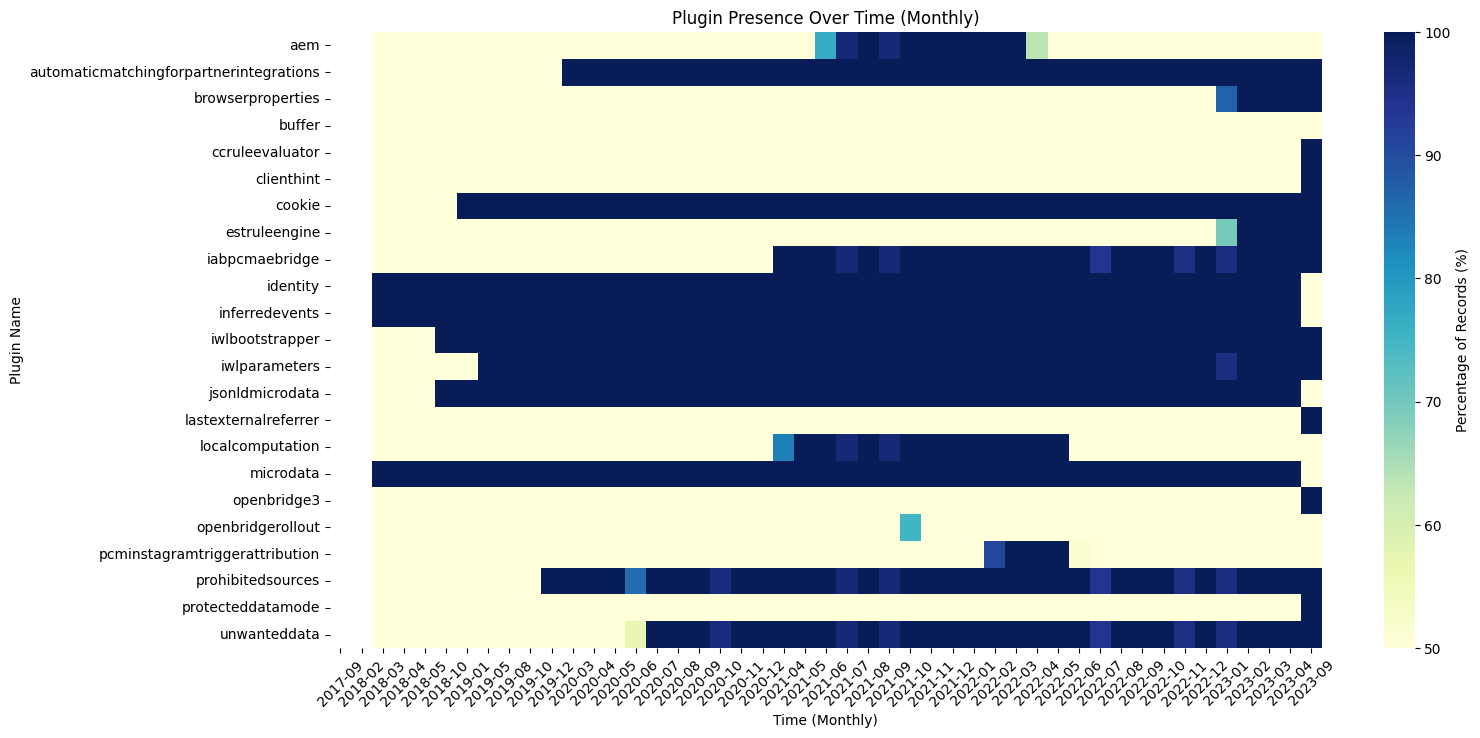

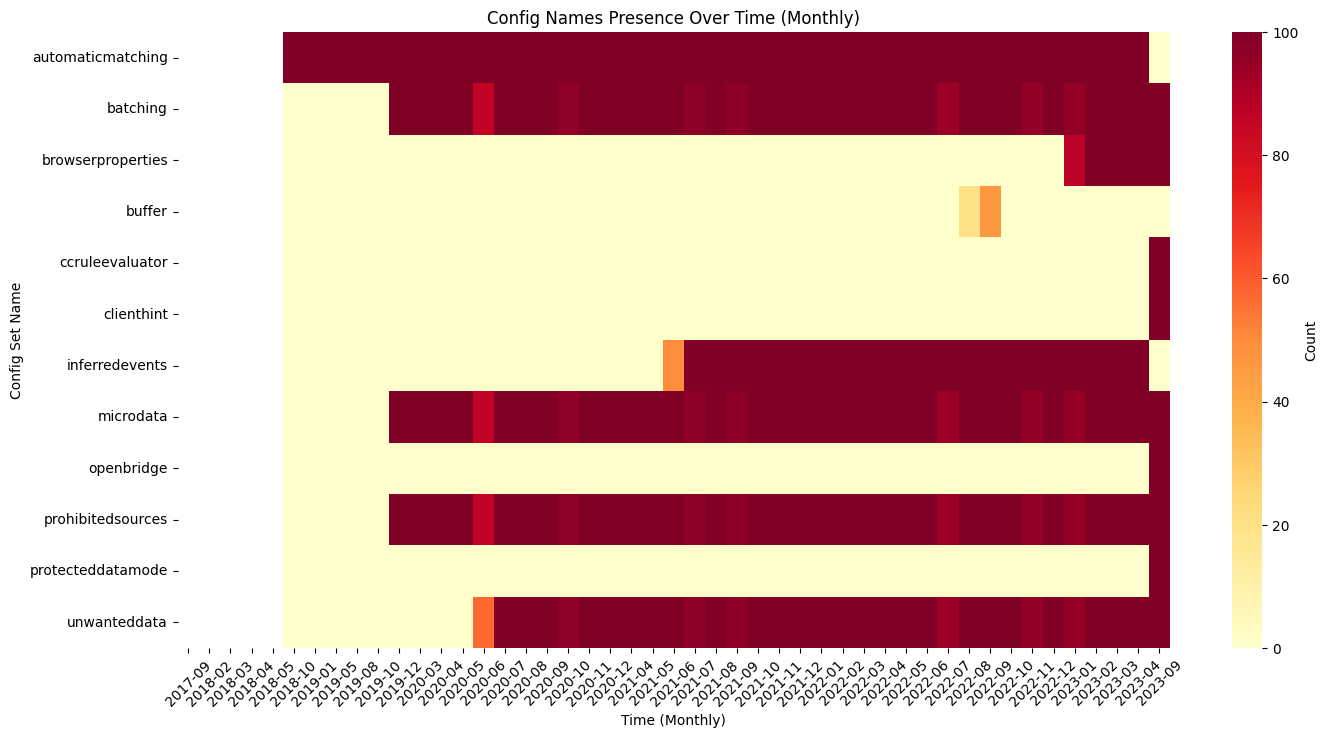

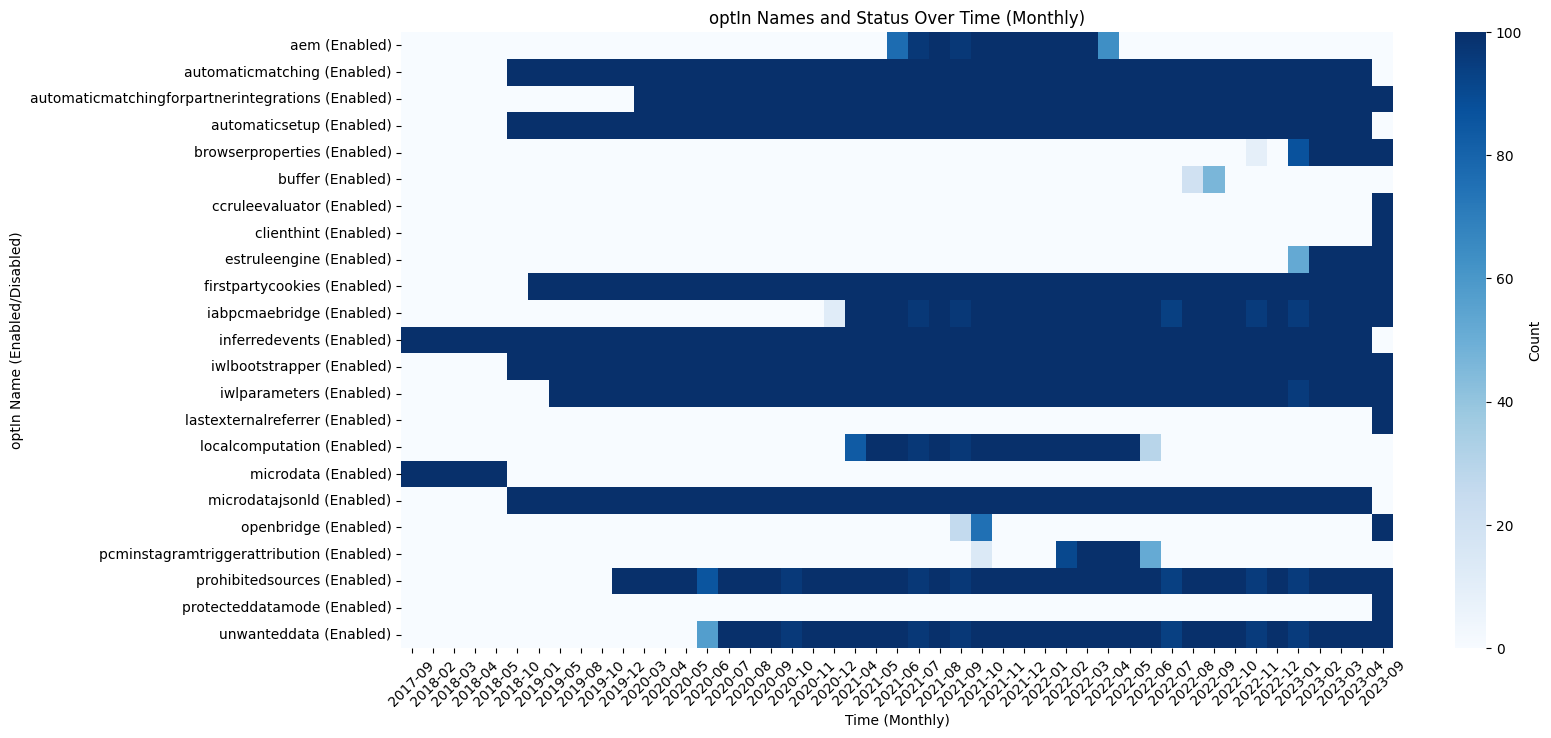

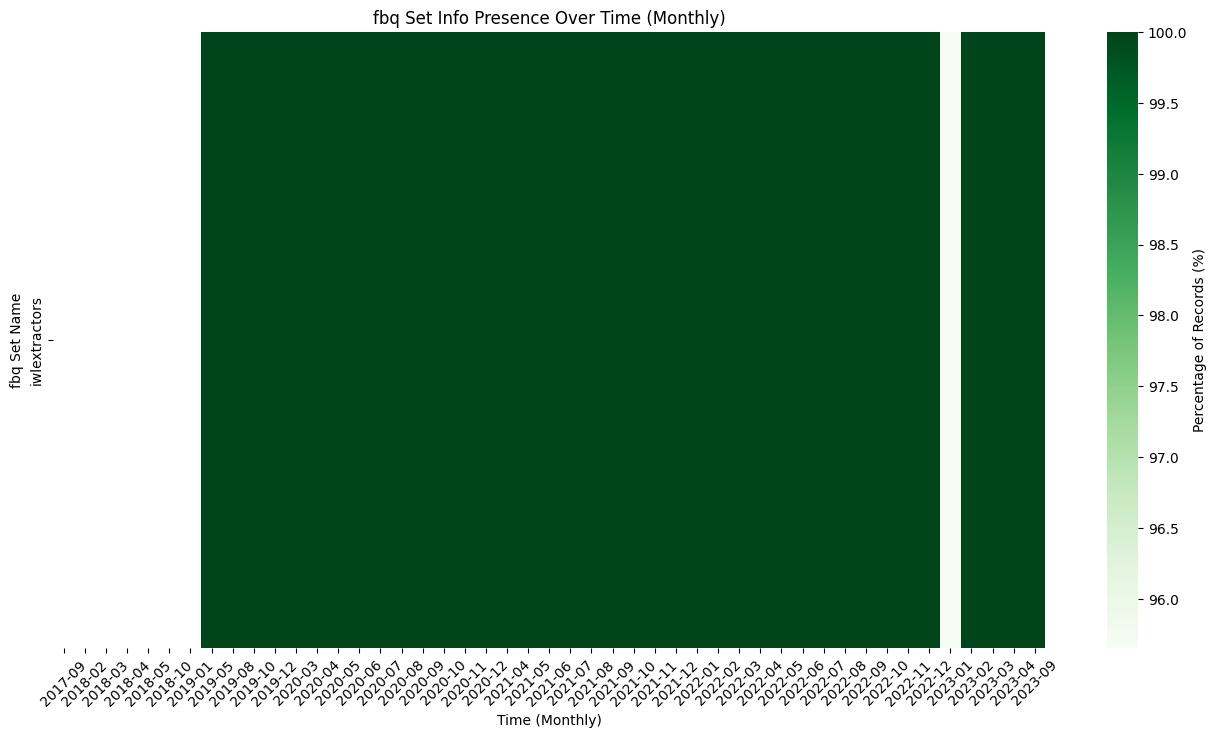

In [224]:
def plot_plugin_presence_heatmap(df):
    # Explode the dataframe to have one row per plugin
    df_exploded = df.explode('plugin_name')
    
    # Create a new column to extract the month from the timestamp
    df_exploded['month'] = df_exploded['timestamp'].dt.to_period('M')
    
    # Count occurrences of each plugin per month
    plugin_counts = df_exploded.groupby(['month', 'plugin_name']).size().unstack(fill_value=0)
    
    # Count total records per month using the original DataFrame
    total_records_per_month = df.groupby(df['timestamp'].dt.to_period('M')).size()
    
    # Calculate percentage presence of each plugin
    plugin_presence = plugin_counts.div(total_records_per_month, axis=0) * 100
    
    # Create a heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(plugin_presence.T, cmap="YlGnBu", cbar_kws={'label': 'Percentage of Records (%)'},vmin=50,vmax=100)
    plt.title('Plugin Presence Over Time (Monthly)')
    plt.ylabel('Plugin Name')
    plt.xlabel('Time (Monthly)')
    plt.xticks(rotation=45)
    plt.show()


def plot_config_names_heatmap(df):
    # Extract config set names from the tuples in config_set_info
    df['config_set_name'] = df['config_set_info'].apply(lambda x: [item[0] for item in x] if isinstance(x, list) else [])
    df_exploded = df.explode('config_set_name')
    df_exploded['month'] = df_exploded['timestamp'].dt.to_period('M')
    plugin_counts = df_exploded.groupby(['month', 'config_set_name']).size().unstack(fill_value=0)
    total_records_per_month = df.groupby(df['timestamp'].dt.to_period('M')).size()

    # Group by timestamp and config_set_name, then count occurrences
    config_presence = plugin_counts.div(total_records_per_month, axis=0) * 100
    
    plt.figure(figsize=(16, 8))
    sns.heatmap(config_presence.T, cmap="YlOrRd", cbar_kws={'label': 'Count'})
    plt.title('Config Names Presence Over Time (Monthly)')
    plt.ylabel('Config Set Name')
    plt.xlabel('Time (Monthly)')
    plt.xticks(rotation=45)
    plt.show()

def plot_optin_names_heatmap(df):
    # Create a new column combining option name and its status
    df['optin_name_status'] = df['opt_in_info'].apply(lambda x: [f"{item[0]} ({'Enabled' if item[1] else 'Disabled'})" for item in x] if isinstance(x, list) else [])

    # Explode the dataframe to have one row per option name status
    df_exploded = df.explode('optin_name_status')
    df_exploded['month'] = df_exploded['timestamp'].dt.to_period('M')
    optin_counts = df_exploded.groupby(['month', 'optin_name_status']).size().unstack(fill_value=0)
    total_records_per_month = df.groupby(df['timestamp'].dt.to_period('M')).size()
    
    # Group by timestamp and option name status, then count occurrences
    option_presence = optin_counts.div(total_records_per_month, axis=0) * 100
    
    # Create heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(option_presence.T, cmap="Blues", cbar_kws={'label': 'Count'})
    plt.title('optIn Names and Status Over Time (Monthly)')
    plt.ylabel('optIn Name (Enabled/Disabled)')
    plt.xlabel('Time (Monthly)')
    plt.xticks(rotation=45)
    plt.show()



def plot_fbq_set_info_heatmap(df):
    # Extract fbq set names from the tuples in fbq_set_info
    df['fbq_set_name'] = df['fbq_set_info'].apply(lambda x: [item[0] for item in x] if isinstance(x, list) else [])
    
    # Explode the dataframe to have one row per fbq set name
    df_exploded = df.explode('fbq_set_name')
    
    df_exploded = df.explode('fbq_set_name')
    df_exploded['month'] = df_exploded['timestamp'].dt.to_period('M')
    fbq_counts = df_exploded.groupby(['month', 'fbq_set_name']).size().unstack(fill_value=0)
    total_records_per_month = df.groupby(df['timestamp'].dt.to_period('M')).size()
    fbq_presence = fbq_counts.div(total_records_per_month, axis=0) * 100

    # Create heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(fbq_presence.T, cmap="Greens", cbar_kws={'label': 'Percentage of Records (%)'})
    plt.title('fbq Set Info Presence Over Time (Monthly)')
    plt.ylabel('fbq Set Name')
    plt.xlabel('Time (Monthly)')
    plt.xticks(rotation=45)
    plt.show()


# Perform EDA
plot_plugin_presence_heatmap(final_aggregated_df)
plot_config_names_heatmap(final_aggregated_df)
plot_optin_names_heatmap(final_aggregated_df)
plot_fbq_set_info_heatmap(final_aggregated_df)




In [208]:
plugi

plugin_name,aem,automaticmatchingforpartnerintegrations,browserproperties,buffer,ccruleevaluator,clienthint,cookie,estruleengine,iabpcmaebridge,identity,...,jsonldmicrodata,lastexternalreferrer,localcomputation,microdata,openbridge3,openbridgerollout,pcminstagramtriggerattribution,prohibitedsources,protecteddatamode,unwanteddata
2017-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,100.0,...,0.0,0.0,0.000000,100.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2018-04,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,100.0,...,0.0,0.0,0.000000,100.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2018-05,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,100.0,...,0.0,0.0,0.000000,100.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2018-10,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,100.0,...,100.0,0.0,0.000000,100.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2019-01,0.000000,0.0,0.000000,0.000000,0.0,0.0,100.0,0.000000,0.000000,100.0,...,100.0,0.0,0.000000,100.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2019-05,0.000000,0.0,0.000000,0.000000,0.0,0.0,100.0,0.000000,0.000000,100.0,...,100.0,0.0,0.000000,100.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2019-08,0.000000,0.0,0.000000,0.000000,0.0,0.0,100.0,0.000000,0.000000,100.0,...,100.0,0.0,0.000000,100.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2019-10,0.000000,0.0,0.000000,0.000000,0.0,0.0,100.0,0.000000,0.000000,100.0,...,100.0,0.0,0.000000,100.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


TypeError: 'int' object is not callable

In [143]:
makeConfigDataframe(extractConfigurationCode('/home/abdullah/dump/Documents/LUMSU/Other/drp2.0/Tracking-Project/riteaid_archived_versions/20181021222450.html'))

,plugin_name,pixel_id,opt_in_config_name,opt_in_enabled,config_set_name,config_set_pixel_id,config_set_data,fbq_set_name,fbq_set_pixel_id,fbq_set_list
0,inferredevents,1264059003707256,inferredevents,true,None,None,None,None,None,None
1,identity,1264059003707256,None,None,None,None,None,None,None,None
2,jsonldmicrodata,1264059003707256,microdatajsonld,true,None,None,None,None,None,None
3,None,None,automaticmatching,true,automaticmatching,1264059003707256,"{'selectedMatchKeys': ['em', 'fn', 'ln', 'ph']}",None,None,None
4,None,None,iwlbootstrapper,true,None,None,None,None,None,None
5,None,None,automaticsetup,true,None,None,None,None,None,None


In [107]:
final_aggregated_df

,plugin_name,opt_in_info,config_set_info,fbq_set_info
0,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]"
1,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]"
2,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]"
3,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]"
4,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]"
...,...,...,...,...
701,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(microdata, {'waitTimeMs': 500}), (automaticm...","[(iwlextractors, [])]"
702,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]"
703,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]"
704,"[inferredevents, identity, jsonldmicrodata, iw...","[(inferredevents, true), (microdatajsonld, tru...","[(inferredevents, {'buttonSelector': 'extended...","[(iwlextractors, [])]"


In [92]:
import pandas as pd
import json
from deepdiff import DeepDiff  # To compare JSONs

def compare_configurations(df1, df2):
    # Step 1: Analyze Presence of Plugins/Opt-ins/Configs/FbqSets
    
    def analyze_presence(df1, df2, column_name):
        set1 = set(df1[column_name].dropna())
        set2 = set(df2[column_name].dropna())
        
        added = set2 - set1
        removed = set1 - set2
        return list(added), list(removed)

    # Analyzing plugins, opt-ins, configs, and fbq sets
    plugin_added, plugin_removed = analyze_presence(df1, df2, 'plugin_name')
    opt_in_added, opt_in_removed = analyze_presence(df1, df2, 'opt_in_config_name')
    config_set_added, config_set_removed = analyze_presence(df1, df2, 'config_set_name')
    fbq_set_added, fbq_set_removed = analyze_presence(df1, df2, 'fbq_set_name')

    presence_report = {
        "Plugins Added": plugin_added,
        "Plugins Removed": plugin_removed,
        "Opt-ins Added": opt_in_added,
        "Opt-ins Removed": opt_in_removed,
        "Config Sets Added": config_set_added,
        "Config Sets Removed": config_set_removed,
        "Fbq Sets Added": fbq_set_added,
        "Fbq Sets Removed": fbq_set_removed
    }
    
    # Step 2: Compare Config_set_data JSON for common configs
    
    def compare_json(json1, json2):
        # Compare two JSON objects using DeepDiff
        diff = DeepDiff(json1, json2, ignore_order=True).to_dict()
        return diff
    
    # Find common config_set_names
    common_configs = set(df1['config_set_name'].dropna()).intersection(set(df2['config_set_name'].dropna()))
    
    json_comparison_report = {}
    
    for config in common_configs:
        # Extract corresponding rows for this config_set_name
        json1 = df1[df1['config_set_name'] == config]['config_set_data'].values
        json2 = df2[df2['config_set_name'] == config]['config_set_data'].values
        
        if json1 and json2:
            json1_data = json.loads(json1[0]) if isinstance(json1[0], str) else json1[0]
            json2_data = json.loads(json2[0]) if isinstance(json2[0], str) else json2[0]
            
            # Compare both JSONs
            json_diff = compare_json(json1_data, json2_data)
            json_comparison_report[config] = json_diff
    
    return presence_report, json_comparison_report

# Example usage
df1 = makeConfigDataframe(base_code)
df2 = makeConfigDataframe(temp)
presence_report, json_comparison_report = compare_configurations(df1, df2)

# Display results
print("Presence Report:")
for key, value in presence_report.items():
    print(f"{key}: {value}")

print("\nJSON Comparison Report:")
for config, diff in json_comparison_report.items():
    print(f"Config Set: {config}")
    print(diff)


Presence Report:
Plugins Added: ['standardparamchecks', 'jsonldmicrodata', 'microdata']
Plugins Removed: []
Opt-ins Added: ['gating', 'microdatajsonld', 'microdata']
Opt-ins Removed: []
Config Sets Added: ['gating']
Config Sets Removed: []
Fbq Sets Added: []
Fbq Sets Removed: []

JSON Comparison Report:
Config Set: microdata
{'dictionary_item_added': ["root['disableMicrodataEvent']", "root['enablePageHash']"], 'values_changed': {"root['waitTimeMs']": {'new_value': 1, 'old_value': 500}}}
Config Set: batching
{}
Config Set: unwanteddata
{}
Config Set: inferredevents
{}
Config Set: clienthint
{}
Config Set: iabpcmaebridge
{}
Config Set: eventvalidation
{}
Config Set: prohibitedsources
{}


In [96]:
import pandas as pd
import json
from deepdiff import DeepDiff

def makeDiffDataframe(df1, df2):
    # Step 1: Analyze Presence of Plugins/Opt-ins/Configs/FbqSets
    
    def analyze_presence(df1, df2, column_name):
        set1 = set(df1[column_name].dropna())
        set2 = set(df2[column_name].dropna())
        
        added = set2 - set1
        removed = set1 - set2
        return list(added), list(removed)

    # Analyze presence differences
    plugin_added, plugin_removed = analyze_presence(df1, df2, 'plugin_name')
    opt_in_added, opt_in_removed = analyze_presence(df1, df2, 'opt_in_config_name')
    config_set_added, config_set_removed = analyze_presence(df1, df2, 'config_set_name')
    fbq_set_added, fbq_set_removed = analyze_presence(df1, df2, 'fbq_set_name')

    # Analyze opt_in_enabled differences for common opt-in configurations
    opt_in_enabled_diff = {}
    common_optins = set(df1['opt_in_config_name'].dropna()).intersection(set(df2['opt_in_config_name'].dropna()))
    
    for opt_in in common_optins:
        enabled1 = df1[df1['opt_in_config_name'] == opt_in]['opt_in_enabled'].values[0]
        enabled2 = df2[df2['opt_in_config_name'] == opt_in]['opt_in_enabled'].values[0]
        if enabled1 != enabled2:
            opt_in_enabled_diff[opt_in] = {'df1': enabled1, 'df2': enabled2}

    presence_report = {
        "Plugins Added": plugin_added,
        "Plugins Removed": plugin_removed,
        "Opt-ins Added": opt_in_added,
        "Opt-ins Removed": opt_in_removed,
        "Config Sets Added": config_set_added,
        "Config Sets Removed": config_set_removed,
        "Fbq Sets Added": fbq_set_added,
        "Fbq Sets Removed": fbq_set_removed,
        "Opt-in Enabled Diff": opt_in_enabled_diff
    }
    
    # Step 2: Compare Config_set_data JSON for common configs
    
    def compare_json(json1, json2):
        diff = DeepDiff(json1, json2, ignore_order=True).to_dict()
        return diff
    
    # Find common config_set_names
    common_configs = set(df1['config_set_name'].dropna()).intersection(set(df2['config_set_name'].dropna()))
    
    json_comparison_report = {}
    
    for config in common_configs:
        json1 = df1[df1['config_set_name'] == config]['config_set_data'].values
        json2 = df2[df2['config_set_name'] == config]['config_set_data'].values
        
        if json1 and json2:
            json1_data = json.loads(json1[0]) if isinstance(json1[0], str) else json1[0]
            json2_data = json.loads(json2[0]) if isinstance(json2[0], str) else json2[0]
            
            # Compare both JSONs
            json_diff = compare_json(json1_data, json2_data)
            json_comparison_report[config] = json_diff
    
    # Step 3: Combine all the results into a DataFrame row
    diff_row = {
        'Plugins Added': plugin_added,
        'Plugins Removed': plugin_removed,
        'Opt-ins Added': opt_in_added,
        'Opt-ins Removed': opt_in_removed,
        'Config Sets Added': config_set_added,
        'Config Sets Removed': config_set_removed,
        'Fbq Sets Added': fbq_set_added,
        'Fbq Sets Removed': fbq_set_removed,
        'Opt-in Enabled Diff': opt_in_enabled_diff,
        'Config JSON Diff': json_comparison_report
    }
    
    return pd.DataFrame([diff_row])

# Example usage
df1 = makeConfigDataframe(base_code)
df2 = makeConfigDataframe(temp)
comparison_df = makeDiffDataframe(df1, df2)

# Display result
(comparison_df)


,Plugins Added,Plugins Removed,Opt-ins Added,Opt-ins Removed,Config Sets Added,Config Sets Removed,Fbq Sets Added,Fbq Sets Removed,Opt-in Enabled Diff,Config JSON Diff
0,"[standardparamchecks, jsonldmicrodata, microdata]",[],"[gating, microdatajsonld, microdata]",[],[gating],[],[],[],{},{'microdata': {'dictionary_item_added': ('root...
